# Importing Data

In [36]:
# Install using "pip install surprise"
import numpy as np
import numba
import matplotlib.pyplot as plt
import sklearn.cluster

In [7]:
# Matrix factorization functions from homework
@numba.jit
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    # Gradient with respect to Ui
    return eta*(reg*Ui-Vj*(Yij-np.dot(Ui.T,Vj)))

@numba.jit
def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    # Gradient with respect to Vj
    return eta*(reg*Vj-Ui*(Yij-np.dot(Vj.T,Ui)))

@numba.jit
def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = 0
    # Compute squared error
    for i,j,Yij in Y:
        i=i-1
        j=j-1
        err = err + (Yij-np.dot(U[i],V[j]))**2
    # Return MSE + regularization
    return err/len(Y)/2+reg/2.0*(np.linalg.norm(U)**2+np.linalg.norm(V)**2)

@numba.jit
def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # initial U and V to random floats from -0.5 to 0.5
    U = np.reshape(np.random.rand(M*K)-0.5,(M,K))
    V = np.reshape(np.random.rand(N*K)-0.5,(N,K))
    # Storage of U,V,err for each epoch
    data = []
    # For eps termination
    preverr = 100
    for epoch in range(0,max_epochs):
        # Shuffles the data before each epoch
        idx=np.random.permutation(np.arange(len(Y)))
        for i,j,Yij in Y[idx]:
            # Convert indices counting from 0
            i=i-1
            j=j-1
            Ui = U[i]
            Vj = V[j]
            # Randomly update U or V
            if np.random.randint(2):                
                U[i]=U[i]-grad_U(Ui, Yij, Vj, reg, eta)
            else:
                V[j]=V[j]-grad_V(Vj, Yij, Ui, reg, eta)
        # Compute the error
        err = get_err(U,V,Y)
        data.append([U,V,err])
        if epoch%5==0:
            print('SGD on epoch ',epoch,', error=',err)
        # Terminate if error reduction is less than eps
        if abs(err-preverr) < eps:
            print('EPS condition reached')
            break
        preverr = err
    # Final output
    data=np.array(data)
    return data[-1,0],data[-1,1],data[-1,2]

In [8]:
# Reader that reads tab-separated data
full = np.loadtxt("./data/data.txt")

# Hyperparameter optimization

Optimize $\lambda$ while fixing $\kappa=20$

In [9]:
%%time
# Plotting code implementations for problem 2E
Y_train = np.loadtxt('./data/train.txt').astype(int)
Y_test = np.loadtxt('./data/test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
K = 20

regs = np.linspace(0,0.5,11)
eta = 0.03 # learning rate

E_train = []
E_val = []
# Use to compute Ein and Eout
for reg in regs:
    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    U,V, e_in = train_model(M, N, K, eta, reg, Y_train)
    E_train.append(e_in)
    eout = get_err(U, V, Y_test)
    E_val.append(eout)

E_train = np.array(E_train)
E_val = np.array(E_val)

Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0
SGD on epoch  0 , error= 0.877973919650997
SGD on epoch  5 , error= 0.3480568008496279
SGD on epoch  10 , error= 0.2798155894191138
SGD on epoch  15 , error= 0.24418368569939788
SGD on epoch  20 , error= 0.22687607415575456
SGD on epoch  25 , error= 0.21368748909847426
EPS condition reached
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.05
SGD on epoch  0 , error= 0.8570183718255124
SGD on epoch  5 , error= 0.37420862875974076
SGD on epoch  10 , error= 0.3131288683870756
SGD on epoch  15 , error= 0.2816945723429503
SGD on epoch  20 , error= 0.26021075381411113
SGD on epoch  25 , error= 0.24505755760737472
SGD on epoch  30 , error= 0.2384309036560942
SGD on epoch  35 , error= 0.23096139758678474
SGD on epoch  40 , error= 0.22472529629563032
SGD on epoch  45 , error= 0.22213971729001553
SGD on epoch  50 , error= 0.22089581605351935
SGD on epoch  55 , error= 0.21711875348420395
SGD on epoch  60 , erro

SGD on epoch  60 , error= 0.5861132373173636
SGD on epoch  65 , error= 0.5834190159218383
SGD on epoch  70 , error= 0.587950836384974
SGD on epoch  75 , error= 0.5707225621431948
SGD on epoch  80 , error= 0.5750575555302614
SGD on epoch  85 , error= 0.5884732798756059
SGD on epoch  90 , error= 0.5909537142071453
SGD on epoch  95 , error= 0.58667918439241
SGD on epoch  100 , error= 0.5848581203019015
SGD on epoch  105 , error= 0.5767872813985855
SGD on epoch  110 , error= 0.5780695142119685
SGD on epoch  115 , error= 0.5789969003889893
SGD on epoch  120 , error= 0.5735706828346782
SGD on epoch  125 , error= 0.5916912586603549
SGD on epoch  130 , error= 0.580267242511604
EPS condition reached
CPU times: user 17min 58s, sys: 12.4 s, total: 18min 10s
Wall time: 18min 1s


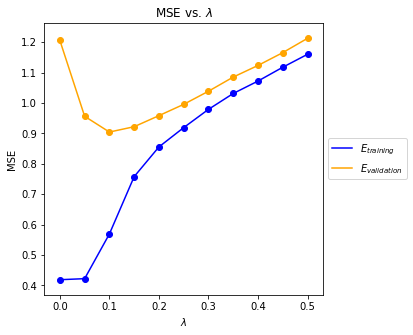

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


In [10]:
# Plot values of E_in across k for each value of lambda
plt.figure(1,figsize=(5,5))
plt.plot(regs, 2*E_train, label='$E_{training}$',color='blue')
plt.scatter(regs, 2*E_train,color='blue')
plt.plot(regs, 2*E_val, label='$E_{validation}$',color='orange')
plt.scatter(regs, 2*E_val,color='orange')
plt.title('MSE vs. $\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('MatrixFactor_hw.png',bbox_inches='tight')
plt.show()
print(regs)

# Training on Full Dataset, Getting Matrices

In [28]:
%%time
# Load data
Y_train = np.loadtxt('./data/train.txt').astype(int)
Y_test = np.loadtxt('./data/test.txt').astype(int)
full = np.loadtxt("./data/data.txt").astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K=20
reg = 0.1plt.scatter(V_PCA[:,0],V_PCA[:,1],c=clusters,s=np.sqrt(avgscores)*10,cmap='jet',alpha=0.5)

eta = 0.03 # learning rate
U,V,err = train_model(M, N, K, eta, reg, full)

Factorizing with  943  users,  1682  movies.
SGD on epoch  0 , error= 0.7652379107944277
SGD on epoch  5 , error= 0.40712469075712465
SGD on epoch  10 , error= 0.37271754588491307
SGD on epoch  15 , error= 0.3538705113275418
SGD on epoch  20 , error= 0.33924713244975463
SGD on epoch  25 , error= 0.3258639350581371
SGD on epoch  30 , error= 0.31798208909624265
SGD on epoch  35 , error= 0.31143336967612717
SGD on epoch  40 , error= 0.30683855468974147
SGD on epoch  45 , error= 0.3024761224786104
SGD on epoch  50 , error= 0.3023728084245042
SGD on epoch  55 , error= 0.2992909496614397
SGD on epoch  60 , error= 0.296834170415647
SGD on epoch  65 , error= 0.2928155761073131
SGD on epoch  70 , error= 0.2931866177126007
SGD on epoch  75 , error= 0.29518182417666694
SGD on epoch  80 , error= 0.2950366006816183
SGD on epoch  85 , error= 0.2900321062624041
EPS condition reached
CPU times: user 2min 6s, sys: 690 ms, total: 2min 6s
Wall time: 2min 6s


# SVD and Projection

In [59]:
# Do SVD (singular value decomposition) on the matrices
A, Sigma, B = np.linalg.svd(V, full_matrices=False) # V = A @ np.diag(Sigma) @ B
# Get PCA representation of movie vector V
V_PCA = np.dot(A[:2],V.T).T

print('Sigma of PCA')
print(Sigma)
print('Variability captured by top 2 components = ',(Sigma[0]+Sigma[1])/np.sum(Sigma))

Sigma of PCA
[66.30414496 19.64751158 14.42090629 13.20168058 12.88015314 11.96365247
 11.64619468 11.43124032 11.21719289 10.74993576 10.33761515 10.25167886
 10.15283153 10.05199746  9.61275263  9.57817569  9.3900327   9.17879571
  8.97224039  8.44563683]
Variability captured by top 2 components =  0.3075915702576896


# Visualization

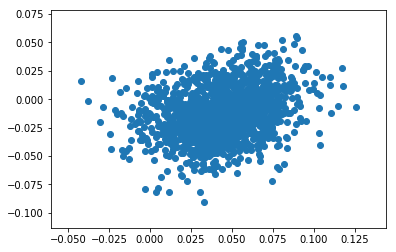

In [39]:
# Scatter the 2 dimensions of the reduced V
plt.scatter(V_PCA[:,0],V_PCA[:,1])
plt.show()

In [40]:
# Save factorization data
out = [U,V,err]
np.save('MatrixFactor_UV_err',out)

In [41]:
class Movie():
    """ Object used to hold a Movie and its properties. """
    def __init__(self, idx, name, genres):
        self.idx = idx
        self.name = name
        self.genres = genres
        self.ratings = []
        self.n_ratings = 0
        self.avg_score = 0
    def add_rating(self, rating):
        """ Update the average rating by taking average * n_ratings = total score. Then add the new rating,
        and then divide by (n_ratings + 1) to get the new average. """
        self.avg_score = (self.avg_score * self.n_ratings + rating) / (self.n_ratings + 1)
        self.n_ratings += 1
        self.ratings.append(rating)
    def __repr__(self):
        return "Movie - Id: {0.idx}, Name: {0.name}, n_ratings = {0.n_ratings}, Avg score = {0.avg_score}".format(self)

In [42]:
# Dictionary that associates each movie ID to its movie object
movies = {}

# Read the list of movies and creates a dictionary of movie objects
with open("./data/movies.txt", "r", encoding="UTF8") as f:
    line = f.readline()
    
    # Split each line by the tab character. The 1st entry is the index, the 2nd entry is the name,
    # the 3rd entries onwards are the genres.
    while line != "":
        line = line.split("\t")
        # Convert the index to an int, convert the genres to a list of ints
        idx, name, genres = int(line[0]), line[1], line[2:]
        movies[idx] = Movie(idx, name, [int(x) for x in genres])
        
        line = f.readline()
        
# Read the ratings files and convert into a list of 3-tuples
def read_data(filename):
    with open(filename, "r") as f:
        data = f.readlines()
    # Split each line by the tab character and convert to a tuple of ints
    return [tuple(map(int, line.split("\t"))) for line in data]
       
full = read_data("./data/data.txt")

# Extract only the ratings from the full dataset
full_ratings = [datapt[2] for datapt in full]

# Go through the entire rating databast and add all the ratings for each movie
for rating_tuple in full:
    user_idx, movie_idx, rating = rating_tuple
    movies[movie_idx].add_rating(rating)

In [43]:
mgenres = np.array([movie.genres for movie in movies.values()])
# Do SVD (singular value decomposition) on the matrices
mA, mSigma, mB = np.linalg.svd(mgenres, full_matrices=False) # V = A @ np.diag(Sigma) @ B
# Get PCA representation of movie vector V
m_PCA = np.dot(mA[:2],mgenres.T).T
print(mSigma)

[28.59300977 22.18153542 19.06464919 14.40791409 14.133702   12.09654028
 10.13151284  9.5836941   9.18053786  8.55881923  8.06087928  7.4621318
  7.06666197  7.00471483  5.15024775  5.11922892  4.63635804  4.2848472
  1.41421356]


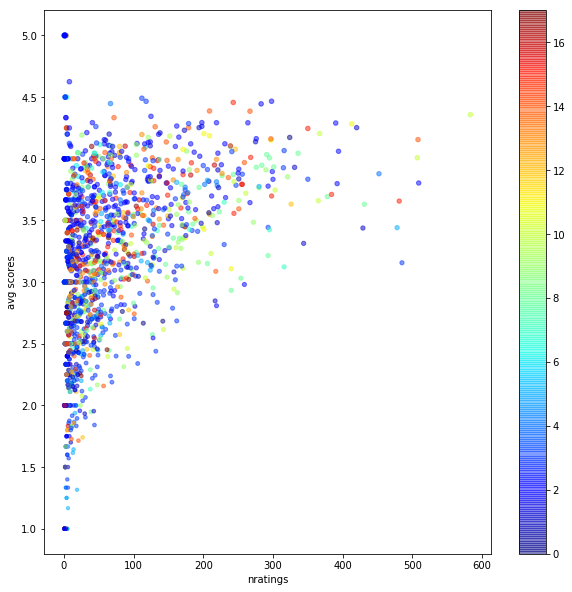

In [54]:
# Scatter the 2 dimensions of the reduced V
avgscores = np.array([movie.avg_score for movie in movies.values()])
nratings = np.array([movie.n_ratings for movie in movies.values()])
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=18)
kmeans.fit(mgenres)
clusters = kmeans.predict(mgenres)

plt.figure(1,figsize=(10,10))
plt.scatter(nratings,avgscores,c=clusters,s=np.sqrt(avgscores)*10,cmap='jet',alpha=0.5)
plt.xlabel('nratings')
plt.ylabel('avg scores')
plt.colorbar()
plt.show()

In [55]:
%%time
# Scatter the 2 dimensions of the reduced V
avgscores = np.array([movie.avg_score for movie in movies.values()])
nratings = np.array([movie.n_ratings for movie in movies.values()])
tsne=sklearn.manifold.TSNE(n_components=2)
tgenres=tsne.fit_transform(mgenres)

CPU times: user 27 s, sys: 2.04 s, total: 29.1 s
Wall time: 29.1 s


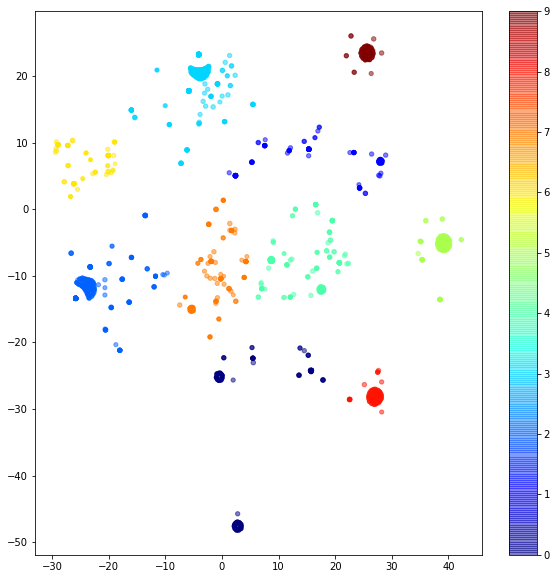

CPU times: user 434 ms, sys: 10.6 ms, total: 445 ms
Wall time: 442 ms


In [56]:
%%time
kmeans = sklearn.cluster.Birch(n_clusters=10)
kmeans.fit(tgenres)
clusters = kmeans.predict(tgenres)

plt.figure(1,figsize=(10,10))
plt.scatter(tgenres[:,0],tgenres[:,1],c=clusters,s=np.sqrt(avgscores)*10,cmap='jet',alpha=0.5)
plt.colorbar()
plt.show()


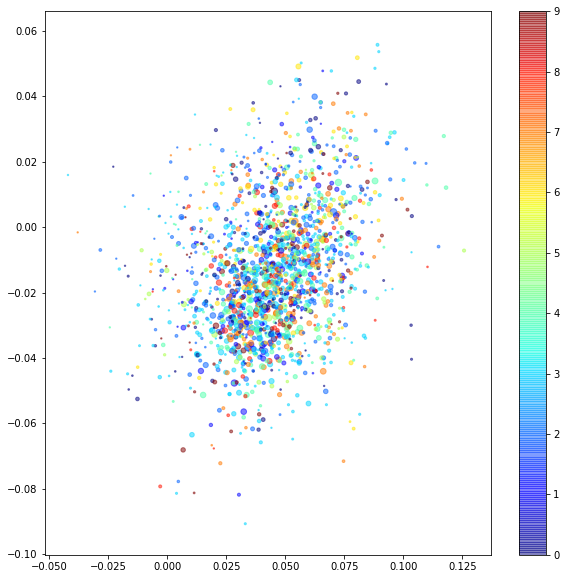

In [68]:
plt.figure(1,figsize=(10,10))
plt.scatter(V_PCA[:,0],V_PCA[:,1],c=clusters,s=np.sqrt(nratings)*2,cmap='jet',alpha=0.5)
plt.colorbar()
plt.show()

In [63]:
print(nratings.shape)

(1682,)
